In [115]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import yfinance as yf
import time
import requests
import itertools
from pykalman import KalmanFilter
import pyarrow.parquet as pq
import warnings

Reading the Candlestick parquet file

In [2]:
df = pd.read_parquet("Stocks_candle_data.parquet")

Converting the index into datetime instead of string, making the index timezone naive to remove inconsistency 

In [3]:
df.index = pd.to_datetime(df.index)        # convert to datetime
df.index = df.index.tz_localize(None)      # remove timezone

Using yfinance to categorize all stocks into respective industries, since there are ~468 stocks -> this leads to 468C2 pairs ~ 110k pairs which are computationally very expensive.
Cointegration is more likely within the same industries.

In [125]:
def get_sector_info(ticker: str, max_retries: int = 5, base_delay: float = 2.0):
    """
    Fetch sector and industry for a given NSE ticker using yfinance,
    with retry and rate-limiting handling.
    """
    for attempt in range(max_retries):
        try:
            
            info = data.get_info()
            
            sector = info.get("sector", "Unknown")
            industry = info.get("industry", "Unknown")
            
            # if both are unknown, might be a bad response → retry
            if sector == "Unknown" and industry == "Unknown" and attempt < max_retries - 1:
                raise ValueError("Empty response, retrying...")
            
            return sector, industry

        except requests.exceptions.HTTPError as e:
            if "429" in str(e):  # Too Many Requests
                sleep_time = base_delay * (2 ** attempt)  # exponential backoff
                print(f"Rate limit hit for {ticker}, sleeping {sleep_time:.1f}s...")
                time.sleep(sleep_time)
            else:
                print(f"HTTP error for {ticker}: {e}")
                break

        except Exception as e:
            # Generic error, retry if attempts remain
            print(f"Error fetching {ticker} (attempt {attempt+1}/{max_retries}): {e}")
            time.sleep(base_delay * (attempt + 1))

    # If all retries fail
    return "Unknown", "Unknown"

In [126]:
tickers = df['Stock'].unique()

yfinance requires ".NS" postscript

In [ ]:
records = []

for ticker in tickers:
    ticker=ticker+".NS"
    data = yf.Ticker(ticker)
    industry = data.info.get("industry", "Unknown")
    records.append({
        "Stock": ticker,
        "Industry": industry
    })

industry_df = pd.DataFrame(records)

I am initially testing cointegration on January 2022 data only -> This is done to avoid look-ahead bias. I have made no trades during this period.
If I test cointegration on the entire data, I am essentially using the entire data (which I won't have access to in actual situations).
I have added the part to periodically retest cointegration to ensure that all the selected pairs are still have that relationship, or to add new pairs that might later become cointegrated. 

Since it is quite difficult to work with the original data format (date x stock gives a unique row) -> I have created a function to pivot the table based on price_col (close/open), giving all the stocks as separate columns. It makes it easier to directly compare corrosponding relationships.

In [6]:
def prepare_wide_df(df, start_date, end_date, price_col="close"):
    # Ensure datetime is a column
    df = df.reset_index().rename(columns={"date": "datetime"})
    df["datetime"] = pd.to_datetime(df["datetime"])
    
    # Filter by date range
    mask = (df["datetime"] >= start_date) & (df["datetime"] <= end_date)
    df = df.loc[mask]

    # Pivot: rows = datetime, columns = stocks, values = close
    wide_df = df.pivot_table(index="datetime", columns="Stock", values=price_col)

    # Sort index and forward-fill missing values
    wide_df = wide_df.sort_index().ffill()

    return wide_df

In [109]:
wide_df_close = prepare_wide_df(df, "2022-01-01", "2022-01-31", "close")

In [110]:
wide_df_open = prepare_wide_df(df, "2022-01-01", "2022-01-31", "open")

In [9]:
wide_df_close.shape

(7500, 468)

To further reduce computation, I am first filtering the stocks based on correlation, within industries. Calculating correlation is significantly faster than calculating cointegration, and as a rule of thumb, cointegration is more likely in highly correlated pairs rather than uncorrelated pairs

In [140]:
def filter_correlation(wide_df, threshold=0.7, method="pearson"):
    corr_matrix = wide_df.corr(method=method)
    correlated_pairs = []
    
    for i, j in itertools.combinations(corr_matrix.columns, 2):
        corr_val = corr_matrix.loc[i, j]
        if abs(corr_val) >= threshold:
            correlated_pairs.append((i, j, corr_val))
    
    return correlated_pairs

Engle-Granger test for cointegration with signficance level of 5% as default

In [141]:
def filter_cointegration(wide_df, stock_pairs=None, significance=0.05):
    """
    if stock_pairs is None:
        stock_pairs = list(itertools.combinations(wide_df.columns, 2))
    
    coint_pairs = []
    
    for stock1, stock2 in stock_pairs:
        series1 = wide_df[stock1].dropna()
        series2 = wide_df[stock2].dropna()
        
        if len(series1) == 0 or len(series2) == 0:
            continue
        
        try:
            score, pvalue, _ = coint(series1, series2)
            if pvalue < significance:
                coint_pairs.append((stock1, stock2, pvalue))
        except Exception:
            continue
    
    return coint_pairs

In [143]:
# Step 1: Filter by correlation
corr_pairs = filter_correlation(wide_df_close, threshold=0.7)
#print("Highly correlated pairs:", corr_pairs)

In [ ]:
# Step 2: Filter by cointegration (using correlated pairs only)
pairs_for_coint = [(s1, s2) for s1, s2, _ in corr_pairs]
coint_pairs = filter_cointegration(wide_df_close, stock_pairs=pairs_for_coint, significance=0.05)
#print("Cointegrated pairs:", coint_pairs)

Because of the insanely large size of the dataset, I faced memory overload issues on Jupyter as well as Colab, since all computation was being done locally with no support for parallel processing (Pyspark could have solved the issue), I had to get a workaround which was to divide the entire dataframe month-wise, now the size of any particular dataframe is workable.

In [70]:
wide_df_close_jan22 = prepare_wide_df(df, "2022-01-01", "2022-01-31", "close")

In [72]:
wide_df_close_feb22 = prepare_wide_df(df, "2022-02-01", "2022-02-28", "close")

In [73]:
wide_df_close_mar22 = prepare_wide_df(df, "2022-03-01", "2022-03-31", "close")

In [74]:
wide_df_close_apr22 = prepare_wide_df(df, "2022-04-01", "2022-04-30", "close")

In [75]:
wide_df_close_may22 = prepare_wide_df(df, "2022-05-01", "2022-05-31", "close")

In [76]:
wide_df_close_jun22 = prepare_wide_df(df, "2022-06-01", "2022-06-30", "close")

In [77]:
wide_df_close_jul22 = prepare_wide_df(df, "2022-07-01", "2022-07-31", "close")

In [78]:
wide_df_close_aug22 = prepare_wide_df(df, "2022-08-01", "2022-08-31", "close")

In [79]:
wide_df_close_sep22 = prepare_wide_df(df, "2022-09-01", "2022-09-30", "close")

In [80]:
wide_df_close_oct22 = prepare_wide_df(df, "2022-10-01", "2022-10-31", "close")

In [81]:
wide_df_close_nov22 = prepare_wide_df(df, "2022-11-01", "2022-11-30", "close")

In [84]:
wide_df_close_dec22 = prepare_wide_df(df, "2022-12-01", "2022-12-31", "close")

In [15]:
wide_df_close_jan23 = prepare_wide_df(df, "2023-01-01", "2023-01-31", "close")

In [16]:
wide_df_close_feb23 = prepare_wide_df(df, "2023-02-01", "2023-02-28", "close")

In [17]:
wide_df_close_mar23 = prepare_wide_df(df, "2023-03-01", "2023-03-31", "close")

In [18]:
wide_df_close_apr23 = prepare_wide_df(df, "2023-04-01", "2023-04-30", "close")

In [19]:
wide_df_close_may23 = prepare_wide_df(df, "2023-05-01", "2023-05-31", "close")

In [20]:
wide_df_close_jun23 = prepare_wide_df(df, "2023-06-01", "2023-06-30", "close")

In [21]:
wide_df_close_jul23 = prepare_wide_df(df, "2023-07-01", "2023-07-31", "close")

In [22]:
wide_df_close_aug23 = prepare_wide_df(df, "2023-08-01", "2023-08-31", "close")

In [23]:
wide_df_close_sep23 = prepare_wide_df(df, "2023-09-01", "2023-09-30", "close")

In [24]:
wide_df_close_oct23 = prepare_wide_df(df, "2023-10-01", "2023-10-31", "close")

In [25]:
wide_df_close_nov23 = prepare_wide_df(df, "2023-11-01", "2023-11-30", "close")

In [26]:
wide_df_close_dec23 = prepare_wide_df(df, "2023-12-01", "2023-12-31", "close")

In [85]:
monthly_dfs = [wide_df_close_jan22, wide_df_close_feb22, wide_df_close_mar22, wide_df_close_apr22, wide_df_close_may22, wide_df_close_jun22, wide_df_close_jul22, wide_df_close_aug22, wide_df_close_sep22, wide_df_close_oct22, wide_df_close_nov22, wide_df_close_dec22, wide_df_close_jan23, wide_df_close_feb23, wide_df_close_mar23, wide_df_close_apr23, wide_df_close_may23, wide_df_close_jun23, wide_df_close_jul23, wide_df_close_aug23, wide_df_close_sep23, wide_df_close_oct23, wide_df_close_nov23, wide_df_close_dec23]

# Strategy

Below is the implementation of the strategy as a single class. The strategy uses Kalman Filter to calculate dynamic hedge ratio, using the data of the last 3 days, which would usually be sufficient and relevant.

The signals are generated through Z-Score. 
Close prices are used for all trades since they are more stable.

To avoid look-ahead bias, at time 't', the close price of 't-1' is used to make a trade, since the close of 't' will not be available.
Since NSE does not allow interday short-selling, all open positions are closed at EOD.

Since the hedge ratio gives the relationship in the spread, and not the actual volume, the volume for each pair is determined to maintain dollar-neutral exposure within a fixed capital allocation per pair. Stock 1’s size is set so the total notional stays within the allocated capital, and stock 2’s size is scaled by the hedge ratio to hedge the position. This ensures the total investment per pair respects the portfolio allocation while reflecting the spread relationship, with transaction costs applied for realistic P&L.

A transaction fee of 0.005% (parameter) has been added to make simulation more realistic.

For risk management, stop loss has been added (0.05 Z-Score), to handle large market down conditions.

Earlier I had planned to use a copula-based strategy, but I was limited due Python not having any extensive copula library, and Colab not being able to install the copula library in R. 
The R code for the main implementation has been provided at the bottom.

In [135]:
# Suppress the PyKalman convergence warning
warnings.filterwarnings('ignore', category=UserWarning)

class PairsTradingBacktest:
    def __init__(self, monthly_dfs_dict, pairs, initial_capital=1_000_000, window=60, stop_loss=0.02, fee_rate=0.0005):
        self.monthly_dfs = monthly_dfs_dict
        self.pairs = pairs
        self.initial_capital = initial_capital
        self.window = window
        self.stop_loss = stop_loss
        self.fee_rate = fee_rate

    def _kalman_hedge_ratio(self, y, x):
        # Reshaping x to (n_timesteps, 1, 1) to match pykalman's expectation
        x = x[:, np.newaxis, np.newaxis]
        
        kf = KalmanFilter(
            transition_matrices=[[1]],
            observation_matrices=x,  # Now correctly shaped as (200, 1, 1)
            initial_state_mean=0,
            initial_state_covariance=1,
            observation_covariance=1,
            transition_covariance=1e-5
        )
        state_means, _ = kf.filter(y)
        return state_means.flatten()[-1]

    def _trade_pair(self, y, x, dates):
        pnl = np.zeros(len(y))
        position = 0  
        entry_price = 0
        
        # Extract dates for easy comparison
        day_change_indices = dates.to_series().diff().dt.days.ne(0)
        
        for t in range(self.window, len(y)):
            hedge_ratio = self._kalman_hedge_ratio(y[t-self.window:t], x[t-self.window:t])
            spread = y[t] - hedge_ratio * x[t]
            spread_window = y[t-self.window:t] - hedge_ratio * x[t-self.window:t]
            spread_mean = np.mean(spread_window)
            spread_std = np.std(spread_window)
            upper = spread_mean + spread_std
            lower = spread_mean - spread_std

            # Check for end-of-day for a potential square-off
            is_end_of_day = day_change_indices.iloc[t]

            # Check entry
            if position == 0:
                if spread > upper:
                    position = -1  # short spread
                    entry_price = spread
                    trade_value = abs(y[t] + hedge_ratio * x[t])
                    pnl[t] -= trade_value * self.fee_rate
                elif spread < lower:
                    position = 1  # long spread
                    entry_price = spread
                    trade_value = abs(y[t] + hedge_ratio * x[t])
                    pnl[t] -= trade_value * self.fee_rate
            
            # Check exit / stop-loss OR End-of-Day Square-off
            elif position != 0:
                exit_signal = (position == 1 and spread >= spread_mean) or (position == -1 and spread <= spread_mean)
                stop_signal = (position == 1 and (spread - entry_price) / entry_price <= -self.stop_loss) or \
                              (position == -1 and (spread - entry_price) / entry_price >= self.stop_loss)
                
                if exit_signal or stop_signal or is_end_of_day:
                    trade_value = abs(y[t] + hedge_ratio * x[t])
                    pnl[t] += position * (spread - entry_price)
                    pnl[t] -= trade_value * self.fee_rate
                    position = 0

        return pnl

    def run_backtest(self):
        daily_equity = [self.initial_capital]
        capital = self.initial_capital
        all_dates = []
        for month, df in self.monthly_dfs.items():
            month_dates = df.index
            all_dates.extend(month_dates)
            month_pnl = np.zeros(len(df))
            for s1, s2 in self.pairs:
                if s1 in df.columns and s2 in df.columns:
                    y = df[s1].values
                    x = df[s2].values
                    # The fix is here: pass the dates variable
                    pair_pnl = self._trade_pair(y, x, month_dates)
                    month_pnl += pair_pnl
                else:
                    print(f"Warning: Pair ({s1}, {s2}) not found in month {month}. Skipping.")

            for day_pnl in month_pnl:
                capital += day_pnl
                daily_equity.append(capital)

        daily_equity_series = pd.Series(daily_equity[1:], index=all_dates)

        returns = daily_equity_series.pct_change().dropna()
        sharpe = returns.mean() / returns.std() * np.sqrt(252)
        cagr = (daily_equity_series.iloc[-1] / daily_equity_series.iloc[0])**(252 / len(daily_equity_series)) - 1
        
        return daily_equity_series, sharpe, cagr

In [145]:
months = [
    "2023-01","2023-02","2023-03","2023-04","2023-05","2023-06",
    "2023-07","2023-08","2023-09","2023-10","2023-11","2023-12",
    "2022-01","2022-02","2022-03","2022-04","2022-05","2022-06",
    "2022-07","2022-08","2022-09","2022-10","2022-11","2022-12"
]

monthly_dfs_dict = dict(zip(months, monthly_dfs))  # convert list to dict

In [123]:
months = [
    "2023-01","2023-02","2023-03","2023-04","2023-05"
]

monthly_dfs_dict = dict(zip(months, monthly_dfs))  # convert list to dict

In [136]:
pairs = [("TCS", "INFY")]
backtest = PairsTradingBacktest(monthly_dfs_dict, pairs)
equity_curve, sharpe, cagr = backtest.run_backtest()

In [ ]:
pairs = coint_pairs
backtest = PairsTradingBacktest(monthly_dfs_dict, pairs)
equity_curve, sharpe, cagr = backtest.run_backtest()

In [137]:
print(sharpe)

-6.471970469794765


In [138]:
print(cagr)

-0.0002549804510021403


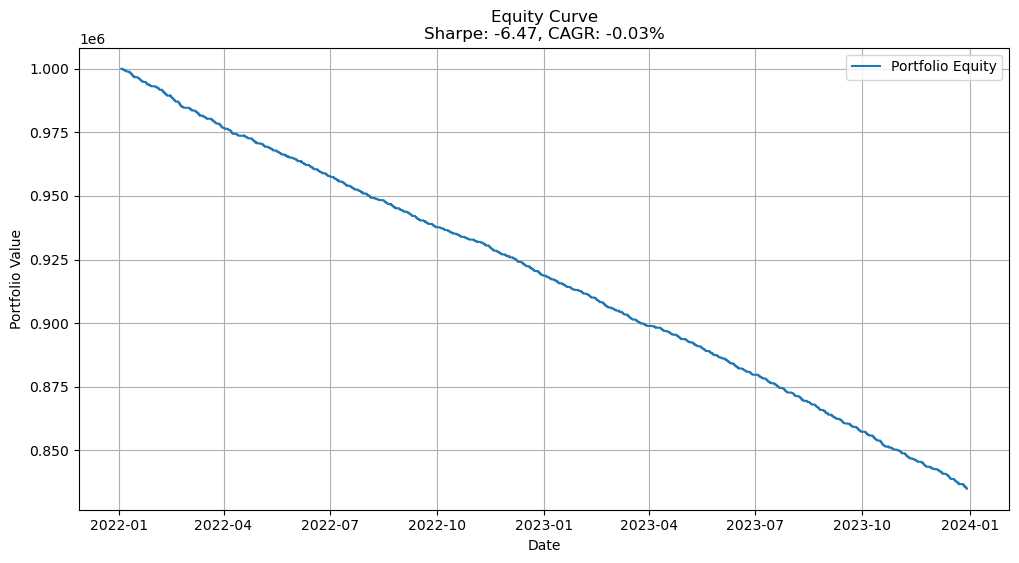

In [139]:
# Plot daily equity curve
plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve.values, label="Portfolio Equity")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title(f"Equity Curve\nSharpe: {sharpe:.2f}, CAGR: {cagr*100:.2f}%")
plt.legend()
plt.grid(True)
plt.show()

# Copula Strategy Code (R)

In [ ]:
"""

  library(quantmod)
  library(copula)
  library(urca)
  library(KFAS)
  library(pracma)
  
  # Transaction Fee Parameters
  fixed_fee <- 1  # Fixed fee per transaction
  percentage_fee <- 0.001  # Percentage of the value of the trade
  
  # Risk-Free Rate Parameters (e.g., 3% annual rate)
  risk_free_annual <- 0.03
  
  # Function to fetch stock data
  extract_df <- function(stocks, start, end, type) {
    if (type=="raw") {
      data1 <- getSymbols(stocks[1], src='yahoo', auto.assign=FALSE, from=start, to=end)
      data2 <- getSymbols(stocks[2], src='yahoo', auto.assign=FALSE, from=start, to=end)
      
      data1 <- Op(data1)
      data2 <- Op(data2)
      
    }
    else {
      data1 <- getSymbols(stocks[1], src='yahoo', auto.assign=FALSE, from=start, to=end)
      data2 <- getSymbols(stocks[2], src='yahoo', auto.assign=FALSE, from=start, to=end)
      
      data1 <- Ad(data1)
      data2 <- Ad(data2)
      
      data1 <- diff(log(data1))
      data2 <- diff(log(data2))
      
    }
    
    df <- data.frame(s1=data1, s2=data2)
    
    return(df)
  }
  
  # Function to compute transaction fee for a trade
  calculate_transaction_fee <- function(trade_value) {
    fee <- fixed_fee + (trade_value * percentage_fee)
    return(fee)
  }
  
  # EM Algorithm
  em <- function(data) {
    # Transform returns to uniform margins using pobs (pseudo-observations)
    u <- pobs(data)
    
    # Step 2: Initialize the copulas
    gaussian_cop <- normalCopula(dim = 2)
    gumbel_cop <- gumbelCopula(dim = 2)
    clayton_cop <- claytonCopula(dim = 2)
    
    # Initial weights for each copula
    initial_weights <- c(1/3, 1/3, 1/3)
    
    # Initial parameter estimates for each copula based on the uniform data
    initial_params <- list(
      gaussian = fitCopula(gaussian_cop, u, method = "ml")@estimate,
      gumbel = fitCopula(gumbel_cop, u, method = "ml")@estimate,
      clayton = fitCopula(clayton_cop, u, method = "ml")@estimate
    )
    
    # Step 3: Function to calculate the density for each copula
    copula_density <- function(u, copula, params) {
      copula <- setTheta(copula, params)  # Set the copula parameters
      return(dCopula(u, copula))
    }
    
    # Step 4: E-step - Calculate responsibilities (gamma values)
    calc_responsibilities <- function(u, weights, params) {
      n <- nrow(u)
      K <- length(weights)  # Number of copulas
      gamma <- matrix(0, n, K)
      
      # Densities for each copula
      densities <- list(
        gaussian = copula_density(u, gaussian_cop, params$gaussian),
        gumbel = copula_density(u, gumbel_cop, params$gumbel),
        clayton = copula_density(u, clayton_cop, params$clayton)
      )
      
      # Calculate responsibilities
      for (k in 1:K) {
        gamma[, k] <- weights[k] * densities[[k]]
      }
      
      # Normalize to make them probabilities
      gamma <- gamma / rowSums(gamma)
      return(gamma)
    }
    
    # Step 5: M-step - Update weights and parameters
    update_parameters <- function(u, gamma) {
      new_weights <- colMeans(gamma)
      
      new_params <- list()
      new_params$gaussian <- fitCopula(gaussian_cop, u, weights = gamma[, 1], method = "ml")@estimate
      new_params$gumbel <- fitCopula(gumbel_cop, u, weights = gamma[, 2], method = "ml")@estimate
      new_params$clayton <- fitCopula(clayton_cop, u, weights = gamma[, 3], method = "ml")@estimate
      
      return(list(weights = new_weights, params = new_params))
    }
    
    # Step 6: Function to calculate the log-likelihood of the mixed copula model
    calc_log_likelihood <- function(u, weights, params) {
      densities <- list(
        gaussian = copula_density(u, gaussian_cop, params$gaussian),
        gumbel = copula_density(u, gumbel_cop, params$gumbel),
        clayton = copula_density(u, clayton_cop, params$clayton)
      )
      
      # Mixed density based on weights
      mixed_density <- weights[1] * densities$gaussian + 
        weights[2] * densities$gumbel + 
        weights[3] * densities$clayton
      
      # Log-likelihood
      log_likelihood <- sum(log(mixed_density))
      return(log_likelihood)
    }
    
    # Step 7: EM algorithm implementation
    em_algorithm <- function(u, initial_weights, initial_params, tol = 1e-6, max_iter = 100) {
      weights <- initial_weights
      params <- initial_params
      log_likelihoods <- c()
      
      for (iter in 1:max_iter) {
        # E-step
        gamma <- calc_responsibilities(u, weights, params)
        
        # M-step
        updates <- update_parameters(u, gamma)
        weights <- updates$weights
        params <- updates$params
        
        # Calculate log-likelihood
        log_likelihood <- calc_log_likelihood(u, weights, params)
        log_likelihoods <- c(log_likelihoods, log_likelihood)
        
        # Check for convergence
        if (iter > 1 && abs(log_likelihoods[iter] - log_likelihoods[iter - 1]) < tol) {
          cat("Convergence reached at iteration:", iter, "\n")
          break
        }
      }
      
      return(list(weights = weights, params = params, log_likelihood = log_likelihoods))
    }
    
    # Run the EM algorithm
    result <- em_algorithm(u, initial_weights, initial_params)
    
    
    # Calculate final AIC using the last log-likelihood and optimized weights
    final_log_likelihood <- calc_log_likelihood(u, result$weights, result$params)
    num_params <- 3  # Three weights to estimate
    final_aic <- -2 * final_log_likelihood + 2 * num_params
    
    # Return results
    return(list(
      weights = result$weights,
      final_params = result$params,
      logLik = final_log_likelihood
    ))
  }
  
  # Rolling function with transaction fee, volatility, and Sharpe ratio including risk-free rate
  rolling <- function(stocks, total_df, test_df, p1, p2, window, multiple) {
    
    cointegration_test <- function(df) {
      jtest <- ca.jo(df, type = "trace", ecdet = "const", K = 2)
      summary(jtest)
      hedge_ratio <- -jtest@V[, 1][2] / jtest@V[, 1][1]
      return(hedge_ratio)
    }
    
    conditional_df <- data.frame(c1=numeric(), c2=numeric())
    
    money <- 1
    position <- 0
    stocks_of_s1 <- 0
    stocks_of_s2 <- 0
    equity <- c(money)
    transaction_fees <- c()
    return_matrix <- matrix(, nrow=nrow(test_df), ncol=5)
    
    weights <- em(tail(total_df, n=window))$weights
    u <- pobs(tail(total_df, n=window))
    
    cop <- mixCopula(c(gaussian_copula(u)$copula, 
                       gumbel_copula(u)$copula, 
                       clayton_copula(u)$copula), 
                     weights)
    
    cop1 <- fitCopula(normalCopula(), u, "ml")@copula
    cop2 <- fitCopula(claytonCopula(), u, "ml")@copula
    cop3 <- fitCopula(gumbelCopula(), u, "ml")@copula
    
    conditional_copula1 <- cCopula(u, cop1)
    conditional_copula2 <- cCopula(u, cop2)
    conditional_copula3 <- cCopula(u, cop3)
    
    new_matrix <- matrix(, nrow=nrow(conditional_copula1), ncol=2)
    new_matrix[, 1] <- weights[1]*conditional_copula1[, 1] + weights[2]*conditional_copula2[, 1] + weights[3]*conditional_copula3[, 1]
    new_matrix[, 2] <- weights[1]*conditional_copula1[, 2] + weights[2]*conditional_copula2[, 2] + weights[3]*conditional_copula3[, 2]
    
    df_c <- as.data.frame(new_matrix)
    
    conditional_df <- rbind(conditional_df, df_c)
    
    count <- 0
    time_fitted <- 1
    
    for (i in 2:nrow(test_df)) {
      if (count >= window) {
        weights <- em(tail(total_df, n=window))$weights
        u <- pobs(tail(total_df, n=window))
        
        cop <- mixCopula(c(gaussian_copula(u)$copula, 
                           gumbel_copula(u)$copula, 
                           clayton_copula(u)$copula), 
                         weights)
        cop1 <- fitCopula(normalCopula(), u, "ml")@copula
        cop2 <- fitCopula(claytonCopula(), u, "ml")@copula
        cop3 <- fitCopula(gumbelCopula(), u, "ml")@copula
        
        conditional_copula1 <- cCopula(u, cop1)
        conditional_copula2 <- cCopula(u, cop2)
        conditional_copula3 <- cCopula(u, cop3)
        
        new_matrix <- matrix(, nrow=nrow(conditional_copula1), ncol=2)
        new_matrix[, 1] <- weights[1]*conditional_copula1[, 1] + weights[2]*conditional_copula2[, 1] + weights[3]*conditional_copula3[, 1]
        new_matrix[, 2] <- weights[1]*conditional_copula1[, 2] + weights[2]*conditional_copula2[, 2] + weights[3]*conditional_copula3[, 2]
        
        df_c <- as.data.frame(new_matrix)
        
        conditional_df <- rbind(conditional_df, df_c)
        
        count <- 0
        time_fitted <- time_fitted + 1
        
      } else {
        count <- count + 1
      }
      
      current_return1 <- (test_df[i, 1] / test_df[i-1, 1]) - 1
      current_return2 <- (test_df[i, 2] / test_df[i-1, 2]) - 1
      new_row <- data.frame(s1=current_return1, s2=current_return2)
      colnames(new_row) <- colnames(total_df)
      total_df <- rbind(total_df, new_row)
      
      hedge_ratio <- cointegration_test(tail(total_df, n=window))
      mat <- pobs(tail(total_df, n=window))
      
      condition1 <- conditional_df[i-1, 1]
      condition2 <- conditional_df[i-1, 2]
      
      return_matrix[i, 1] <- condition1
      return_matrix[i, 2] <- condition2
      return_matrix[i, 3] <- hedge_ratio
      #return_matrix[i, 4] <- logLik(compare_copulas(tail(total_df, n=window)))
      
      # Opening rules
      if ((condition1 > 0.5 && condition2 > 0.5) && position != 0) {
        trade_value <- as.numeric(abs(stocks_of_s1 * test_df[i, 1]) + abs(stocks_of_s2 * test_df[i, 2]))
        fee <- calculate_transaction_fee(trade_value)
        money <- as.numeric(money + as.numeric((stocks_of_s1 * test_df[i, 1]) + (stocks_of_s2 * test_df[i, 2])) - fee)
        position <- 0
        stocks_of_s1 <- 0
        stocks_of_s2 <- 0
        equity <- c(equity, money)
      }
      else if ((condition1 <= p1 && condition2 >= p2) && position == 0) {
        trade_value <- as.numeric((test_df[i, 1] * multiple) + (hedge_ratio * multiple * test_df[i, 2]))
        fee <- calculate_transaction_fee(trade_value)
        stocks_of_s1 <- stocks_of_s1 + (1 * multiple)
        stocks_of_s2 <- stocks_of_s2 - (hedge_ratio * multiple)
        money <- as.numeric(money - (test_df[i, 1] * multiple) + (hedge_ratio * multiple * test_df[i, 2]))
        position <- 1
        transaction_fees <- c(transaction_fees, fee)
        equity <- c(equity, money)
      } 
      else if ((condition1 >= p2 && condition2 <= p1) && position == 0) {
        trade_value <- as.numeric((test_df[i, 1] * multiple) + (hedge_ratio * multiple * test_df[i, 2]))
        fee <- calculate_transaction_fee(trade_value)
        stocks_of_s1 <- stocks_of_s1 - (1 * multiple)
        stocks_of_s2 <- stocks_of_s2 + (hedge_ratio * multiple)
        money <- as.numeric(money + (test_df[i, 1] * multiple) - (hedge_ratio * multiple * test_df[i, 2]))
        position <- -1
        transaction_fees <- c(transaction_fees, fee)
        equity <- c(equity, money)
      }
      return_matrix[i, 4] <- stocks_of_s1
      return_matrix[i, 5] <- stocks_of_s2
    }
    
    # Calculate volatility (standard deviation of returns)
    daily_returns <- diff(equity) / head(equity, -1)
    volatility <- sd(daily_returns)
    
    CAGR <- sqrt(money) - 1 
    
    # Calculate Sharpe Ratio (with risk-free rate)
    sharpe_ratio <- CAGR * sqrt(252) / volatility
    
    return(list(
      returns = money,
      transaction_fees = transaction_fees,
      volatility = volatility,
      cagr = CAGR,
      equity = equity,
      times = time_fitted,
      sharpe = sharpe_ratio,
      daily = daily_returns,
      mat = return_matrix
    ))
    
  }
  
  
  selected_pairs <- list(
    c("AMZN", "ADBE"), c("V", "ACN"), c("V", "ADBE"), c("MA", "LIN"),
    c("V", "PYPL"), c("HON", "LIN"), c("MA", "DHR"), c("NEE", "LIN"),
    c("AMZN", "NFLX"), c("HD", "TXN"), c("MA", "COST"), c("WMT", "LIN"),
    c("V", "COST"), c("AMZN", "PYPL"), c("WMT", "ACN"), c("GOOGL", "ADBE"),
    c("HD", "LIN"), c("HD", "MA"), c("HD", "ADBE"), c("NFLX", "ADBE"),
    c("HON", "TXN"), c("MCD", "LIN"), c("UNH", "ADBE"), c("MCD", "NEE"),
    c("AMZN", "GOOGL"), c("NKE", "COST"), c("ACN", "COST"), c("HON", "DHR"),
    c("AAPL", "MSFT"), c("MCD", "ACN"), c("UNH", "NFLX"), c("WMT", "COST"),
    c("CSCO", "ACN"), c("HD", "COST"), c("CSCO", "LIN"), c("MCD", "DHR"),
    c("CSCO", "HON"), c("NKE", "NEE"), c("MCD", "UNP"), c("CSCO", "DHR"),
    c("WMT", "TXN"), c("MRK", "LLY"), c("HON", "COST"), c("NKE", "ACN"),
    c("GOOGL", "NFLX"), c("NKE", "LIN")
  )
  
  
  
  test_start <- '2021-01-01'
  test_end <- '2023-01-01'
  buffer_start <- '2019-01-01'
  buffer_end <- '2020-12-31'
  p1 <- 0.1
  p2 <- 0.9
  window <- 250
  multiple <- 36.5
  
  
  final_df <- data.frame(stock1=character(), stock2=character(), volatility=numeric(), sharpe_ratio=numeric(), cagr=numeric())
  
  for(pair in selected_pairs){
    total_df <- extract_df(pair, buffer_start, buffer_end, "returns")
    test_df <- extract_df(pair, test_start, test_end, "raw")
    
    results <- rolling(pair, total_df, test_df, p1, p2, window, multiple)
    
    temp_df <- data.frame(
      stock1=pair[1],
      stock2=pair[2],
      volatility=results$volatility,
      sharpe_ratio=results$sharpe,
      cagr=results$cagr
    )
    
    final_df <- rbind(final_df, temp_df)
  }
  
  print(final_df)
  
  # Export the data frame to a CSV file
  #write.csv(final_df, file = "Strategy Result.csv", row.names = FALSE)


"""